## 1- LinearSVC algorithm with Multiple Cores

This experiment tests how changing the number of CPU cores affects runtime, speedup, efficiency, scalability, accuracy, and F1-score when training a LinearSVC model using PySpark.

### Steps:
1. Load or download the dataset and save it as a parquet file.  
2. For each number of cores, create a Spark session.  
3. Clean and preprocess the text data.  
4. Split the data into train/test sets.  
5. Build a pipeline with Tokenizer, StopWordsRemover, TF-IDF, and LinearSVC.  
6. Train and test the model, measure runtime, and calculate performance metrics.  
7. Collect results and print a summary.  
8. Visualize results using plots for runtime, speedup, efficiency, accuracy, and F1-score.  


In [3]:
# Import the libraries I will use for data, spark and machine learning
import findspark
findspark.init()

import time
import os
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from huggingface_hub import login

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, trim, size, split
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

In [4]:
hf_token = os.getenv("HF_TOKEN") #my private token to access data

In [17]:
# download dataset if parquet not exists
local_parquet = "metahate_train.parquet"
if not os.path.exists(local_parquet):

    login(hf_token)
    
    dataset = load_dataset("irlab-udc/metahate", split="train")
    df = dataset.to_pandas()[['text', 'label']]
    df.to_parquet(local_parquet, engine="pyarrow", index=False)

In [18]:
df = pd.read_parquet(local_parquet, engine="pyarrow")
print(f"Count: {len(df)}, : {df.columns.tolist()}\n")

Count: 1101165, : ['text', 'label']



In [19]:
# Missing values check
print(df.isnull().sum(), "\n")


text     1
label    0
dtype: int64 



In [20]:
# Basic stats for text length
df['text_length'] = df['text'].str.len()
print(df['text_length'].describe(), "\n")


count    1.101164e+06
mean     2.738461e+02
std      5.131642e+02
min      1.000000e+00
25%      7.500000e+01
50%      1.340000e+02
75%      2.710000e+02
max      2.003000e+04
Name: text_length, dtype: float64 



In [22]:
display(df.sample(10, random_state=42))

,text,label,text_length
284414,==Talk:Co-Freemasonry== I left the message t...,0,267.0
580667,damn this Xmas party. I want to be home playin...,0,56.0
988971,NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKEN* Plea...,0,155.0
585073,This computer is sh*t,0,21.0
615581,a mixed raced person is a mutt,1,30.0
342299,` ::Now that all of the issues have been addre...,0,129.0
725510,I'm from africa i like this son bruh,0,36.0
689442,@user @user f*** would retard block create ult...,0,78.0
736894,"Obstruction, collusion, stupidity. aloha and...",1,65.0
972913,NEWLINE_TOKEN*What in the world are you talkin...,0,56.0


In [23]:
print(df['label'].value_counts(), "\n")

label
0    867876
1    233289
Name: count, dtype: int64 



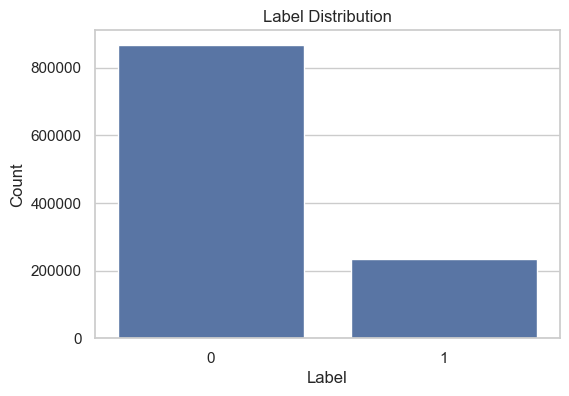

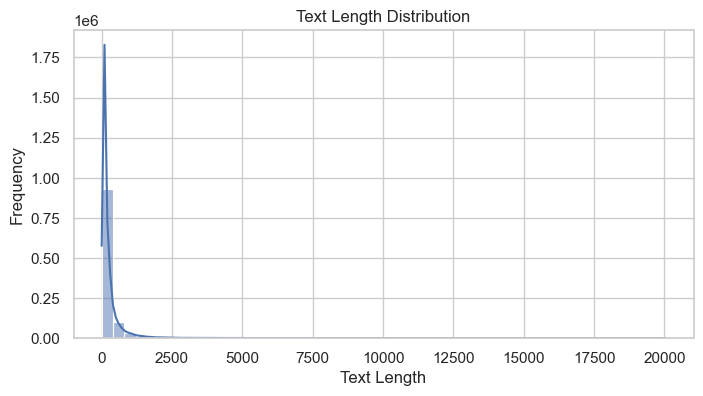

In [25]:
# Visualization
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title("Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

In [13]:
# cores list and baseline time
cores_list = [1, 2, 4, 8, 12]   
baseline_time = None      


In [7]:
# loop over cores and run LinearSVC
results = []

for c in cores_list:
    print(f"\n===== Running LinearSVC with {c} core =====")

    # create spark session and read parquet
    spark = SparkSession.builder.appName(f"MetaHate_LinearSVC_{c}core").master(f"local[{c}]").config("spark.driver.memory", "4g").config("spark.executor.memory", "4g").config("spark.ui.port", "0").getOrCreate()

    # clean text, remove duplicates, and filter words
    spark_df = spark.read.parquet(local_parquet)
    spark_df = spark_df.withColumn("label", col("label").cast(IntegerType()))
    spark_df = spark_df.filter((col("text").isNotNull()) & (trim(col("text")) != ""))
    spark_df = spark_df.dropDuplicates(["text", "label"])
    spark_df = spark_df.withColumn("clean_text", lower(col("text")))
    spark_df = spark_df.withColumn("clean_text", regexp_replace(col("clean_text"), r"http\S+", ""))
    spark_df = spark_df.withColumn("clean_text", regexp_replace(col("clean_text"), "&amp;", "and"))
    spark_df = spark_df.withColumn("clean_text", regexp_replace(col("clean_text"), r"[^a-zA-Z0-9\s]", ""))
    spark_df = spark_df.withColumn("word_count", size(split(col("clean_text"), " ")))
    spark_df = spark_df.filter((col("word_count") >= 1) & (col("word_count") <= 200))
    spark_df = spark_df.repartition(max(20, c*5)).persist()

    
# split data to train/test
# train model, test, and measure time

    train_df, test_df = spark_df.randomSplit([0.8, 0.2], seed=42)
    train_df = train_df.cache()
    test_df = test_df.cache()

    # build pipeline with tokenizer, remover, TF-IDF, and SVC
    tokenizer = Tokenizer(inputCol="clean_text", outputCol="words")
    remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
    hashingTF = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=2**15)
    idf = IDF(inputCol="raw_features", outputCol="features").setMinDocFreq(2)
    svc = LinearSVC(featuresCol="features", labelCol="label", maxIter=15, regParam=0.05)

    pipeline_svc = Pipeline(stages=[tokenizer, remover, hashingTF, idf, svc])

In [1]:
    start = time.time()
    model_svc = pipeline_svc.fit(train_df)
    pred_svc = model_svc.transform(test_df)
    pred_svc.count()  # force execution
    end = time.time()

    pipeline_time = end - start

    if c == 1:
        baseline_time = pipeline_time
        print(f"Baseline set to {baseline_time:.2f} seconds (Single Core)")
        
    # calculate speedup, efficiency, scalability
    speedup = baseline_time / pipeline_time
    efficiency = speedup / c
    scalability = efficiency * 100 

    evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    
    # evaluate accuracy and f1-score
    accuracy = evaluator_acc.evaluate(pred_svc)
    f1_score = evaluator_f1.evaluate(pred_svc)

    # save results and stop spark

    results.append({
        "Cores": c,
        "RunTime (s)": round(pipeline_time, 2),
        "Speedup": round(speedup, 2),
        "Efficiency": round(efficiency, 4),
        "Scalability ": round(scalability, 2),
        "Accuracy": round(accuracy, 4),
        "F1-score": round(f1_score, 4)
    })


    spark_df.unpersist()
    spark.stop()

# print summary results
results_df = pd.DataFrame(results)
results_df_filtered = results_df[results_df["Cores"] != 1]

print("\n=====  Result  =====")
print(results_df_filtered.to_string(index=False))


===== Running LinearSVC with 1 core =====
Baseline set to 285.73 seconds (Single Core)

===== Running LinearSVC with 2 core =====

===== Running LinearSVC with 4 core =====

===== Running LinearSVC with 8 core =====

===== Running LinearSVC with 12 core =====

=====  Result  =====
 Cores  RunTime (s)  Speedup  Efficiency  Scalability   Accuracy  F1-score
     2       195.41     1.46      0.7311         73.11    0.8422    0.8260
     4       154.59     1.85      0.4621         46.21    0.8430    0.8269
     8       140.44     2.03      0.2543         25.43    0.8427    0.8262
    12       137.00     2.09      0.1738         17.38    0.8435    0.8278


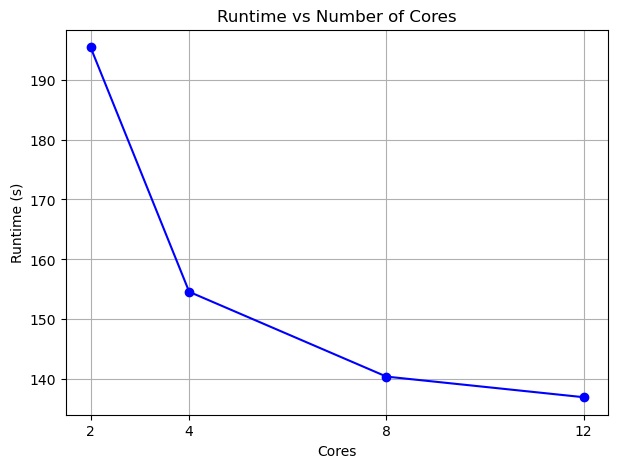

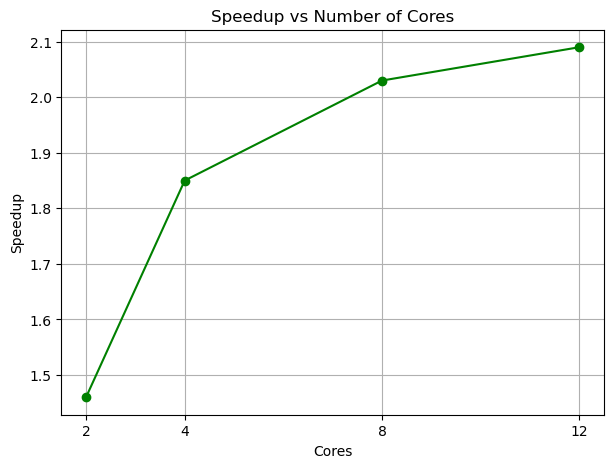

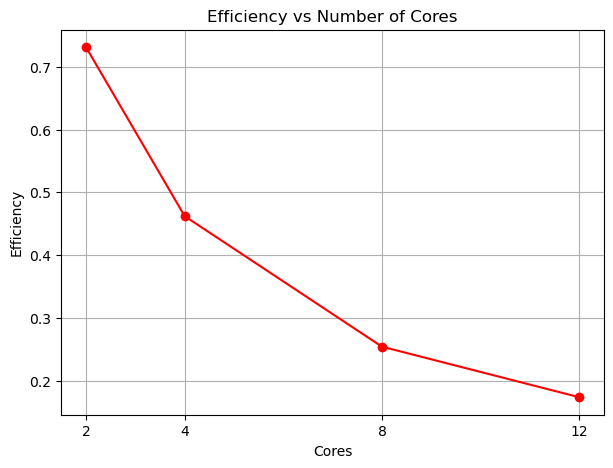

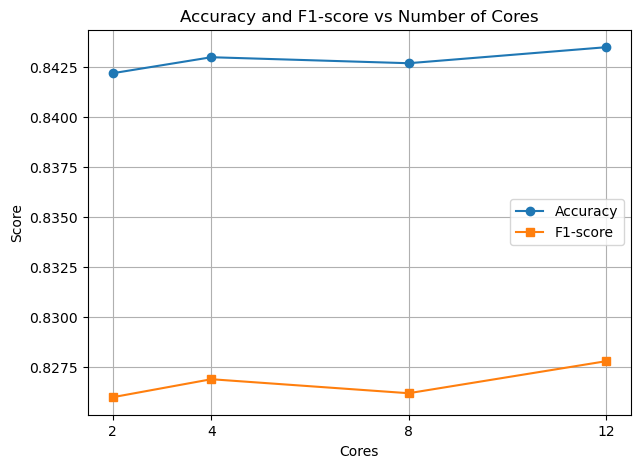

In [11]:
#LinearSVC plot Results 
data = {
    "Cores": [2, 4, 8, 12],
    "RunTime (s)": [195.41, 154.59, 140.44, 137.00],
    "Speedup": [1.46, 1.85, 2.03, 2.09],
    "Efficiency": [0.7311, 0.4621, 0.2543, 0.1738],
    "Scalability": [73.11, 46.21, 25.43, 17.38],
    "Accuracy": [0.8422, 0.8430, 0.8427, 0.8435],
    "F1-score": [0.8260, 0.8269, 0.8262, 0.8278]
}

df = pd.DataFrame(data)

# function for consistent plots
def plot_metric(y, title, color="blue", marker="o", ylabel=""):
    plt.figure(figsize=(7,5))
    plt.plot(df["Cores"], df[y], marker=marker, color=color)
    plt.title(title)
    plt.xlabel("Cores")
    plt.ylabel(ylabel if ylabel else y)
    plt.xticks(df["Cores"])
    plt.grid(True)
    plt.show()

# Plots
plot_metric("RunTime (s)", "Runtime vs Number of Cores", "blue", "o", "Runtime (s)")
plot_metric("Speedup", "Speedup vs Number of Cores", "green", "o", "Speedup")
plot_metric("Efficiency", "Efficiency vs Number of Cores", "red", "o", "Efficiency")

# Accuracy and F1-score
plt.figure(figsize=(7,5))
plt.plot(df["Cores"], df["Accuracy"], marker='o', label="Accuracy")
plt.plot(df["Cores"], df["F1-score"], marker='s', label="F1-score")
plt.title("Accuracy and F1-score vs Number of Cores")
plt.xlabel("Cores")
plt.ylabel("Score")
plt.xticks(df["Cores"])  
plt.legend()
plt.grid(True)
plt.show()


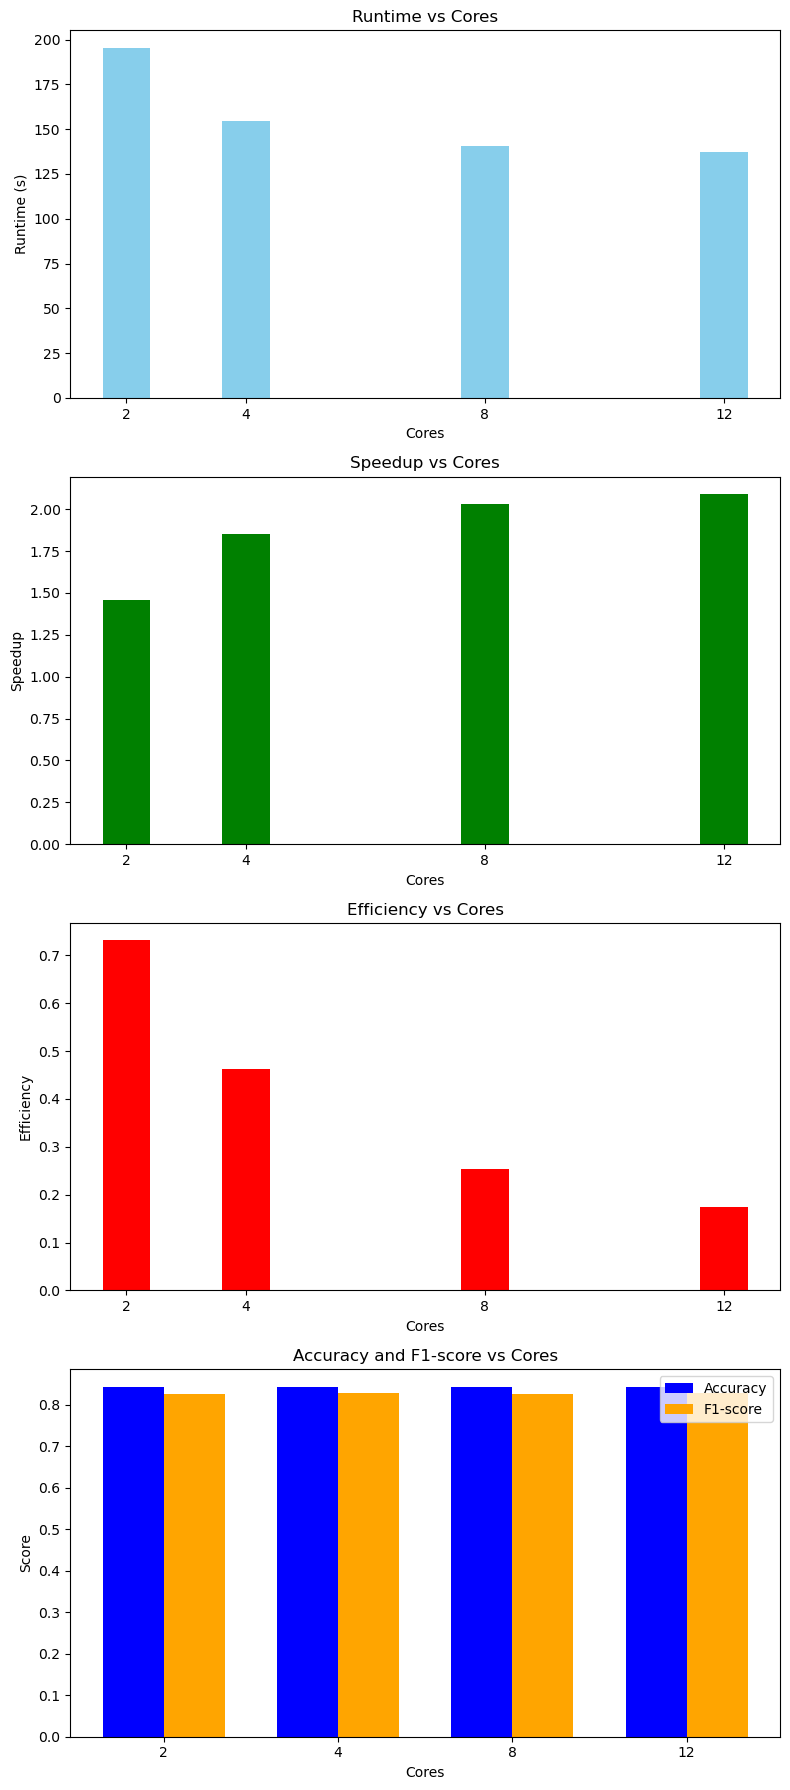

In [12]:
# Results 
data = {
    "Cores": [2, 4, 8, 12],
    "RunTime (s)": [195.41, 154.59, 140.44, 137.00],
    "Speedup": [1.46, 1.85, 2.03, 2.09],
    "Efficiency": [0.7311, 0.4621, 0.2543, 0.1738],
    "Scalability": [73.11, 46.21, 25.43, 17.38],
    "Accuracy": [0.8422, 0.8430, 0.8427, 0.8435],
    "F1-score": [0.8260, 0.8269, 0.8262, 0.8278]
}

df = pd.DataFrame(data)

fig, axes = plt.subplots(4, 1, figsize=(8, 18))

# Runtime
axes[0].bar(df["Cores"], df["RunTime (s)"], color="skyblue")
axes[0].set_title("Runtime vs Cores")
axes[0].set_xlabel("Cores")
axes[0].set_ylabel("Runtime (s)")
axes[0].set_xticks(df["Cores"])

# Speedup
axes[1].bar(df["Cores"], df["Speedup"], color="green")
axes[1].set_title("Speedup vs Cores")
axes[1].set_xlabel("Cores")
axes[1].set_ylabel("Speedup")
axes[1].set_xticks(df["Cores"])

# Efficiency
axes[2].bar(df["Cores"], df["Efficiency"], color="red")
axes[2].set_title("Efficiency vs Cores")
axes[2].set_xlabel("Cores")
axes[2].set_ylabel("Efficiency")
axes[2].set_xticks(df["Cores"])

# Accuracy & F1-score
width = 0.35
x = range(len(df["Cores"]))
axes[3].bar([i - width/2 for i in x], df["Accuracy"], width, label="Accuracy", color="blue")
axes[3].bar([i + width/2 for i in x], df["F1-score"], width, label="F1-score", color="orange")
axes[3].set_title("Accuracy and F1-score vs Cores")
axes[3].set_xlabel("Cores")
axes[3].set_ylabel("Score")
axes[3].set_xticks(x)
axes[3].set_xticklabels(df["Cores"])
axes[3].legend()

plt.tight_layout()
plt.show()


## 2- Logistic Regression algorithm with Multiple Cores

This experiment evaluates how the number of CPU cores impacts runtime, speedup, efficiency, scalability, accuracy, and F1-score when training a Logistic Regression algorithm PySpark.

### Steps:
1. Import required libraries and initialize Spark.  
2. Load or download the dataset and save it as a parquet file.  
3. For each number of cores, create a Spark session.  
4. Clean and preprocess the text data.  
5. Split the data into train/test sets.  
6. Build a pipeline with Tokenizer, StopWordsRemover, TF-IDF, and Logistic Regression.  
7. Train and test the model, measure runtime, and calculate performance metrics.  
8. Collect results and print a summary.  
9. Visualize results using plots for runtime, speedup, efficiency, accuracy, and F1-score.  


In [13]:
# Import the libraries I will use for data, spark and machine learning
import findspark
findspark.init()

import time
import os
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from huggingface_hub import login

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, trim, size, split
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

In [14]:
 # download dataset if not exists
local_parquet = "metahate_train.parquet"
if not os.path.exists(local_parquet):
    login(hf_token)
    dataset = load_dataset("irlab-udc/metahate", split="train")
    df = dataset.to_pandas()[['text', 'label']]
    df.to_parquet(local_parquet, engine="pyarrow", index=False)

In [ ]:
# cores list and baseline time
cores_list = [1, 2, 4, 8, 12]   
baseline_time = None          

In [8]:
# store results for all cores
results = []

for c in cores_list:
    print(f"\n===== Running Logistic Regression with {c} core =====")

    # Spark session core
    spark = (SparkSession.builder.appName(f"Logistic Regression{c}core").master(f"local[{c}]").config("spark.driver.memory", "4g").config("spark.executor.memory", "4g").config("spark.ui.port", "0").getOrCreate())

    spark_df = spark.read.parquet(local_parquet)
    spark_df = spark_df.withColumn("label", col("label").cast(IntegerType()))
    spark_df = spark_df.filter((col("text").isNotNull()) & (trim(col("text")) != ""))
    spark_df = spark_df.dropDuplicates(["text", "label"])
    spark_df = spark_df.withColumn("clean_text", lower(col("text")))
    spark_df = spark_df.withColumn("clean_text", regexp_replace(col("clean_text"), r"http\S+", ""))
    spark_df = spark_df.withColumn("clean_text", regexp_replace(col("clean_text"), "&amp;", "and"))
    spark_df = spark_df.withColumn("clean_text", regexp_replace(col("clean_text"), r"[^a-zA-Z0-9\s]", ""))
    spark_df = spark_df.withColumn("word_count", size(split(col("clean_text"), " ")))
    spark_df = spark_df.filter((col("word_count") >= 1) & (col("word_count") <= 200))
    spark_df = spark_df.repartition(max(20, c*5)).persist()

    train_df, test_df = spark_df.randomSplit([0.8, 0.2], seed=42)
    train_df = train_df.cache()
    test_df = test_df.cache()

    tokenizer = Tokenizer(inputCol="clean_text", outputCol="words")
    remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
    hashingTF = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=2**15)
    idf = IDF(inputCol="raw_features", outputCol="features").setMinDocFreq(2)

    # logistic regression model
    logreg = LogisticRegression(
        featuresCol="features",
        labelCol="label",
        maxIter=20,
        regParam=0.05,
        elasticNetParam=0.0
    )
    
    # build pipeline with tokenizer, remover, TF-IDF, and SVC
    pipeline_logreg = Pipeline(stages=[tokenizer, remover, hashingTF, idf, logreg])

In [1]:
    # Train & evaluate

    start = time.time()# start measuring how long training

    # Train the Logistic Regression model
    model_logreg = pipeline_logreg.fit(train_df)
    pred_logreg = model_logreg.transform(test_df)
    pred_logreg.count() 
    end = time.time()

    runtime = end - start

    # Evaluators to check how good the model is

    evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

    # Get accuracy and F1-score of the model

    accuracy = evaluator_acc.evaluate(pred_logreg)
    f1_score = evaluator_f1.evaluate(pred_logreg)

    if c == 1:
        baseline_time = runtime
        print(f"Baseline set to {baseline_time:.2f} seconds (Single Core)")

    # Compare with baseline to see how much faster it is
    speedup = baseline_time / runtime
    # How well cores are being used
    efficiency = speedup / c
    scalability = efficiency * 100

    # Store results for this number of cores
    results.append({
        "Cores": c,
        "Accuracy": round(accuracy, 4),
        "F1-score": round(f1_score, 4),
        "Runtime": round(runtime, 2),
        "Speedup": round(speedup, 2),
        "Efficiency": round(efficiency, 4),
        "Scalability": round(scalability, 2),
    })

    # Clear Spark memory and stop session
    spark_df.unpersist()
    spark.stop()

results_df = pd.DataFrame(results)
results_df_filtered = results_df[results_df["Cores"] != 1]  

# Print the table of results
print("\n===== Result =====")
print(results_df_filtered.to_string(index=False))



===== Running Logistic Regression with 1 core =====
Baseline set to 300.02 seconds (Single Core)

===== Running Logistic Regression with 2 core =====

===== Running Logistic Regression with 4 core =====

===== Running Logistic Regression with 8 core =====

===== Running Logistic Regression with 12 core =====

===== Result =====
 Cores  Accuracy  F1-score  Runtime  Speedup  Efficiency  Scalability
     2    0.8339    0.8123   199.16     1.51      0.7532        75.32
     4    0.8344    0.8125   156.87     1.91      0.4781        47.81
     8    0.8343    0.8123   142.79     2.10      0.2626        26.26
    12    0.8339    0.8120   145.19     2.07      0.1722        17.22


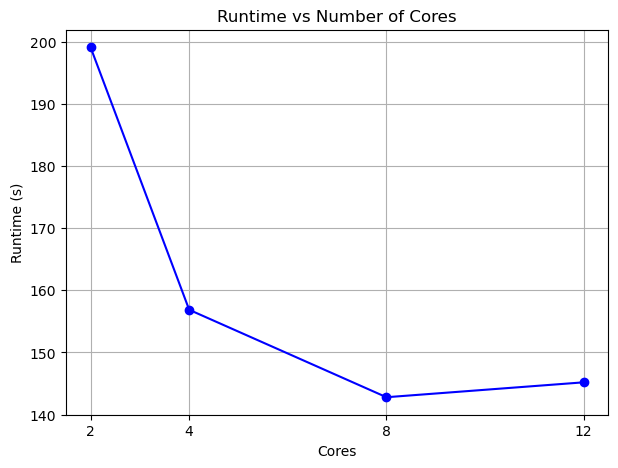

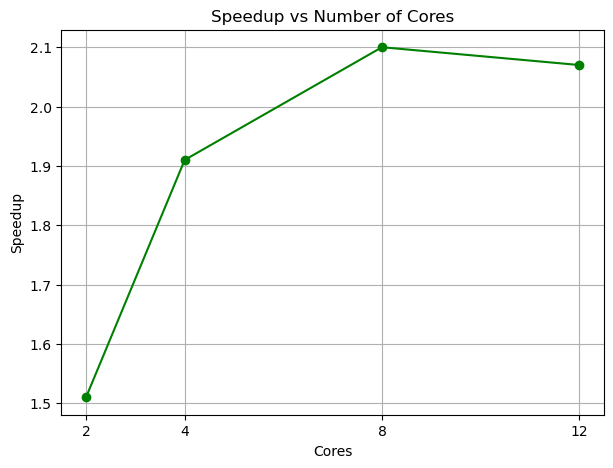

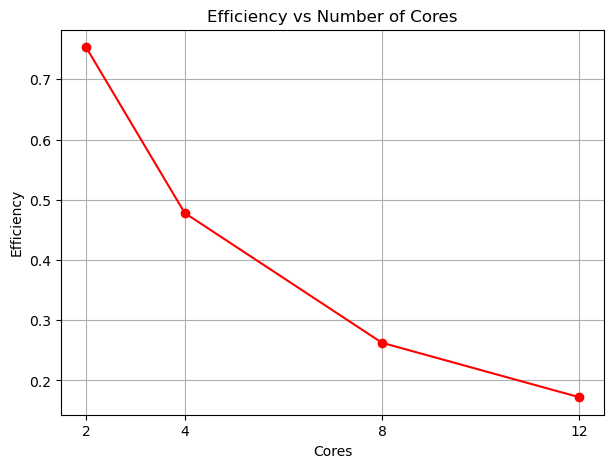

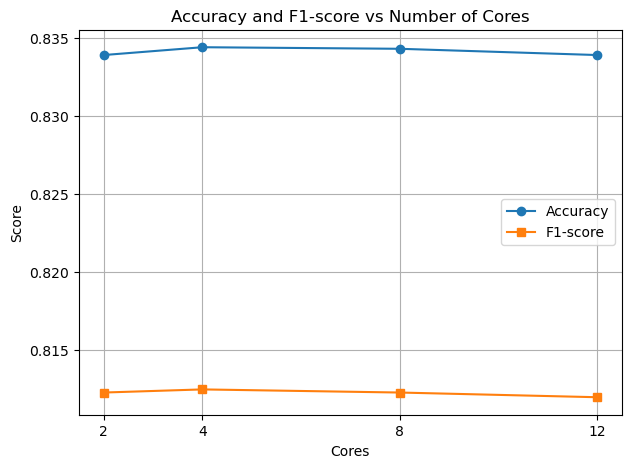

In [15]:
# Logistic Regression Results data
data = {
    "Cores": [2, 4, 8, 12],
    "RunTime (s)": [199.16, 156.87, 142.79, 145.19],
    "Speedup": [1.51, 1.91, 2.10, 2.07],
    "Efficiency": [0.7532, 0.4781, 0.2626, 0.1722],
    "Scalability": [75.32, 47.81, 26.26, 17.22],
    "Accuracy": [0.8339, 0.8344, 0.8343, 0.8339],
    "F1-score": [0.8123, 0.8125, 0.8123, 0.8120]
}

df = pd.DataFrame(data)

# function for consistent plots
def plot_metric(y, title, color="blue", marker="o", ylabel=""):
    plt.figure(figsize=(7,5))
    plt.plot(df["Cores"], df[y], marker=marker, color=color)
    plt.title(title)
    plt.xlabel("Cores")
    plt.ylabel(ylabel if ylabel else y)
    plt.xticks(df["Cores"])
    plt.grid(True)
    plt.show()

# Plots
plot_metric("RunTime (s)", "Runtime vs Number of Cores", "blue", "o", "Runtime (s)")
plot_metric("Speedup", "Speedup vs Number of Cores", "green", "o", "Speedup")
plot_metric("Efficiency", "Efficiency vs Number of Cores", "red", "o", "Efficiency")

# Accuracy and F1-score
plt.figure(figsize=(7,5))
plt.plot(df["Cores"], df["Accuracy"], marker='o', label="Accuracy")
plt.plot(df["Cores"], df["F1-score"], marker='s', label="F1-score")
plt.title("Accuracy and F1-score vs Number of Cores")
plt.xlabel("Cores")
plt.ylabel("Score")
plt.xticks(df["Cores"])  
plt.legend()
plt.grid(True)
plt.show()


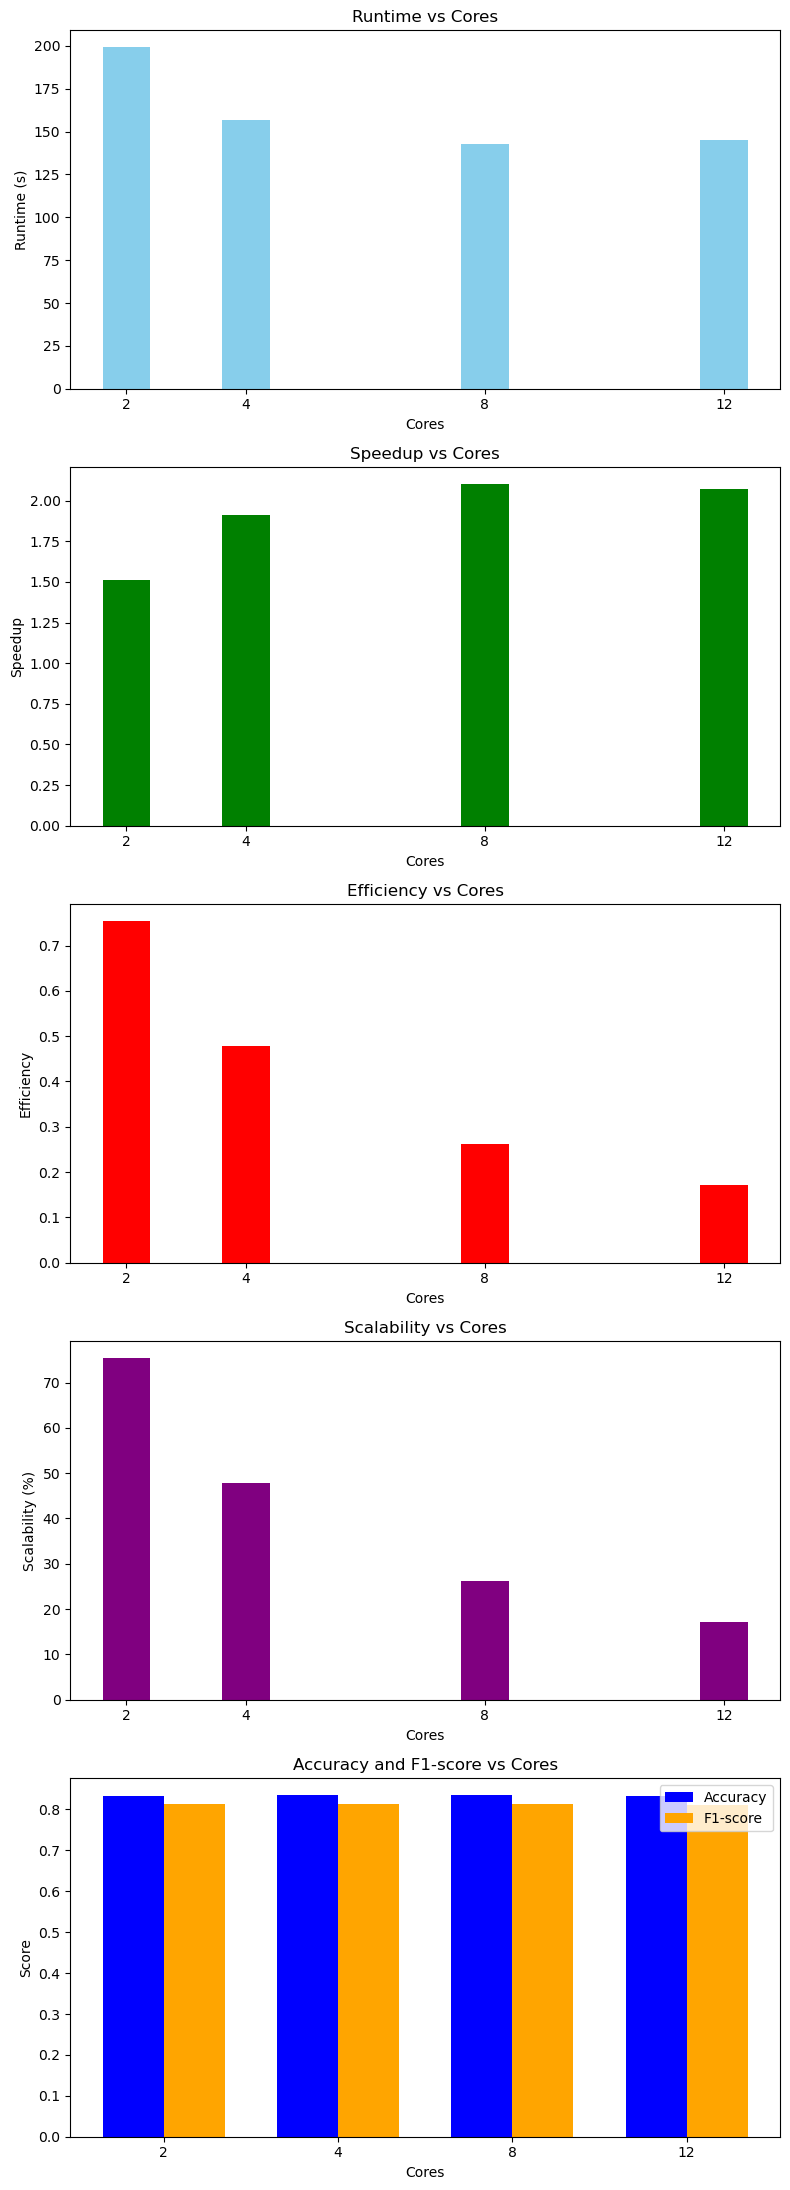

In [16]:
# Logistic Regression Results
data = {
    "Cores": [2, 4, 8, 12],
    "RunTime (s)": [199.16, 156.87, 142.79, 145.19],
    "Speedup": [1.51, 1.91, 2.10, 2.07],
    "Efficiency": [0.7532, 0.4781, 0.2626, 0.1722],
    "Scalability": [75.32, 47.81, 26.26, 17.22],
    "Accuracy": [0.8339, 0.8344, 0.8343, 0.8339],
    "F1-score": [0.8123, 0.8125, 0.8123, 0.8120]
}

df = pd.DataFrame(data)

fig, axes = plt.subplots(5, 1, figsize=(8, 22))

# Runtime
axes[0].bar(df["Cores"], df["RunTime (s)"], color="skyblue")
axes[0].set_title("Runtime vs Cores")
axes[0].set_xlabel("Cores")
axes[0].set_ylabel("Runtime (s)")
axes[0].set_xticks(df["Cores"])

# Speedup
axes[1].bar(df["Cores"], df["Speedup"], color="green")
axes[1].set_title("Speedup vs Cores")
axes[1].set_xlabel("Cores")
axes[1].set_ylabel("Speedup")
axes[1].set_xticks(df["Cores"])

# Efficiency
axes[2].bar(df["Cores"], df["Efficiency"], color="red")
axes[2].set_title("Efficiency vs Cores")
axes[2].set_xlabel("Cores")
axes[2].set_ylabel("Efficiency")
axes[2].set_xticks(df["Cores"])

# Scalability
axes[3].bar(df["Cores"], df["Scalability"], color="purple")
axes[3].set_title("Scalability vs Cores")
axes[3].set_xlabel("Cores")
axes[3].set_ylabel("Scalability (%)")
axes[3].set_xticks(df["Cores"])

# Accuracy & F1-score
width = 0.35
x = range(len(df["Cores"]))
axes[4].bar([i - width/2 for i in x], df["Accuracy"], width, label="Accuracy", color="blue")
axes[4].bar([i + width/2 for i in x], df["F1-score"], width, label="F1-score", color="orange")
axes[4].set_title("Accuracy and F1-score vs Cores")
axes[4].set_xlabel("Cores")
axes[4].set_ylabel("Score")
axes[4].set_xticks(x)
axes[4].set_xticklabels(df["Cores"])
axes[4].legend()

plt.tight_layout()
plt.show()


## NaiveBayes algorithm with Multiple Cores

This experiment evaluates how the number of CPU cores impacts runtime, speedup, efficiency, scalability, accuracy, and F1-score when training a NaiveBayes algorithm using PySpark.

### Steps:
1. Import required libraries and initialize Spark.  
2. Load or download the dataset and save it as a parquet file.  
3. For each number of cores, create a Spark session.  
4. Clean and preprocess the text data.  
5. Split the data into train/test sets.  
6. Build a pipeline with Tokenizer, StopWordsRemover, TF-IDF, and Logistic Regression.  
7. Train and test the model, measure runtime, and calculate performance metrics.  
8. Collect results and print a summary.  
9. Visualize results using plots for runtime, speedup, efficiency, accuracy, and F1-score.  


In [9]:
# Import the libraries I will use for data, spark and machine learning
import findspark
findspark.init()

import time
import os
import pandas as pd
from datasets import load_dataset
from huggingface_hub import login
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, trim, size, split
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, NGram, CountVectorizer, IDF
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

In [10]:
# cores list and baseline time
cores_list = [1, 2, 4, 8, 12]   
baseline_time = None            

# download dataset if not exists
local_parquet = "metahate_train.parquet"
if not os.path.exists(local_parquet):
    login(hf_token)
    dataset = load_dataset("irlab-udc/metahate", split="train")
    df = dataset.to_pandas()[['text', 'label']]
    df.to_parquet(local_parquet, engine="pyarrow", index=False)

In [11]:
results = []

for c in cores_list:
    print(f"\n===== Running NaiveBayes with {c} core =====")
    
    # create a Spark session with specific core count and memory settings
    spark = (SparkSession.builder.appName(f"NaiveBayes_{c}core ").master(f"local[{c}]").config("spark.driver.memory", "4g").config("spark.executor.memory", "4g").config("spark.ui.port", "0").getOrCreate()
    )

    # Load and clean data
    spark_df = spark.read.parquet(local_parquet)
    spark_df = spark_df.withColumn("label", col("label").cast(IntegerType()))

    # remove rows with null and empty text and duplicates
    spark_df = spark_df.filter((col("text").isNotNull()) & (trim(col("text")) != ""))
    spark_df = spark_df.dropDuplicates(["text", "label"])

    # text cleaning lowercase, remove URLs, HTML entities, non alphanumeric chars
    spark_df = spark_df.withColumn("clean_text", lower(col("text")))
    spark_df = spark_df.withColumn("clean_text", regexp_replace(col("clean_text"), r"http\S+", ""))
    spark_df = spark_df.withColumn("clean_text", regexp_replace(col("clean_text"), "&amp;", "and"))
    spark_df = spark_df.withColumn("clean_text", regexp_replace(col("clean_text"), r"[^a-zA-Z0-9\s]", ""))
    spark_df = spark_df.withColumn("word_count", size(split(col("clean_text"), " ")))
    spark_df = spark_df.filter((col("word_count") >= 1) & (col("word_count") <= 200))
    spark_df = spark_df.repartition(c*2).persist()

    # split into train/test sets 80% train and 20% test
    train_df, test_df = spark_df.randomSplit([0.8, 0.2], seed=42)
    train_df = train_df.cache()
    test_df = test_df.cache()

    # tokenizer + Stopwords + NGram + CountVectorizer + IDF + NaiveBayes
    tokenizer = Tokenizer(inputCol="clean_text", outputCol="words")
    remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

    bigram = NGram(n=2, inputCol="filtered_words", outputCol="bigrams")
    cv = CountVectorizer(inputCol="bigrams", outputCol="raw_features", vocabSize=2**15, minDF=2)
    idf = IDF(inputCol="raw_features", outputCol="features")

    nb = NaiveBayes(featuresCol="features", labelCol="label", modelType="multinomial")

    #chain all preprocessing + model stages
    pipeline_nb = Pipeline(stages=[tokenizer, remover, bigram, cv, idf, nb])


In [1]:
# Train model and predict
    start = time.time()

#Fit the Naive Bayes on training data
    model_nb = pipeline_nb.fit(train_df)
    pred_nb = model_nb.transform(test_df)
    pred_nb.count()  
    end = time.time()

    runtime = end - start #total runtime for this core setting

    evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

    accuracy = evaluator_acc.evaluate(pred_nb)
    f1_score = evaluator_f1.evaluate(pred_nb)

    if c == 1:
        baseline_time = runtime
        print(f"Baseline set to {baseline_time:.2f} seconds (Single Core, No Parallelism)")

    speedup = baseline_time / runtime
    efficiency = speedup / c
    scalability = efficiency * 100

    results.append({
        "Cores": c,
        "Accuracy": round(accuracy, 4),
        "F1-score": round(f1_score, 4),
        "Runtime": round(runtime, 2),
        "Speedup": round(speedup, 2),
        "Efficiency": round(efficiency, 4),
        "Scalability": round(scalability, 2),
    })

    # Clear Spark memory and stop session

    spark_df.unpersist()
    spark.stop()

#Print values
results_df = pd.DataFrame(results)
results_df_filtered = results_df[results_df["Cores"] != 1]

print("\n===== Result =====")
print(results_df_filtered.to_string(index=False))


===== Running NaiveBayes with 1 core =====
Baseline set to 317.89 seconds (Single Core, No Parallelism)

===== Running NaiveBayes with 2 core =====

===== Running NaiveBayes with 4 core =====

===== Running NaiveBayes with 8 core =====

===== Running NaiveBayes with 12 core =====

===== Result =====
 Cores  Accuracy  F1-score  Runtime  Speedup  Efficiency  Scalability
     2    0.7264    0.7448   225.43     1.41      0.7051        70.51
     4    0.7262    0.7444   180.04     1.77      0.4414        44.14
     8    0.7242    0.7429   156.09     2.04      0.2546        25.46
    12    0.7247    0.7430   150.16     2.12      0.1764        17.64


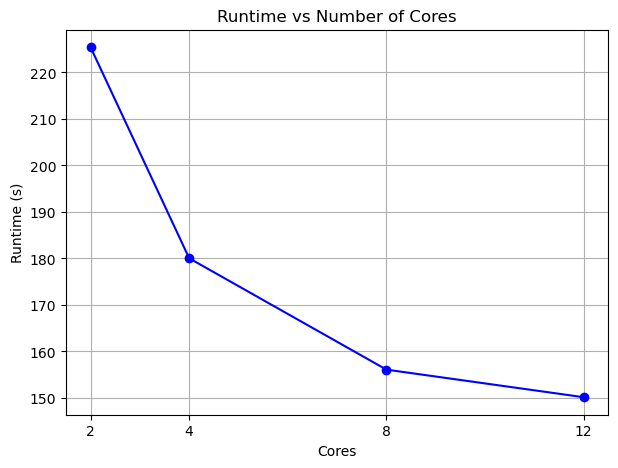

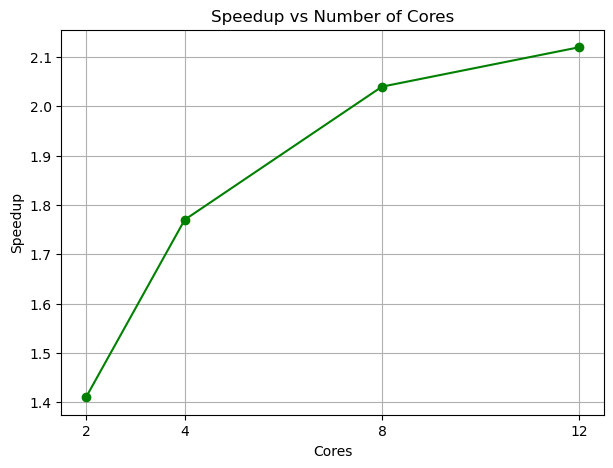

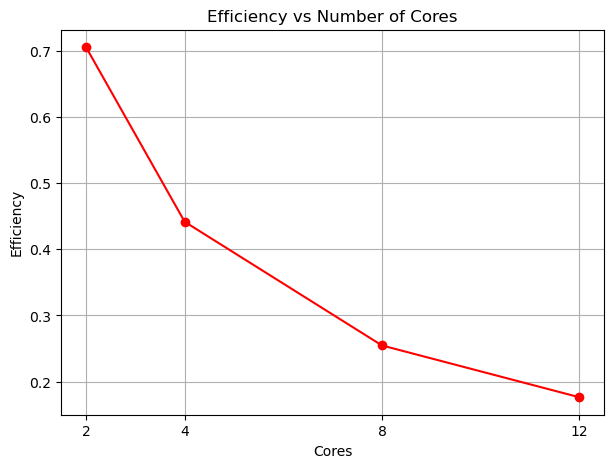

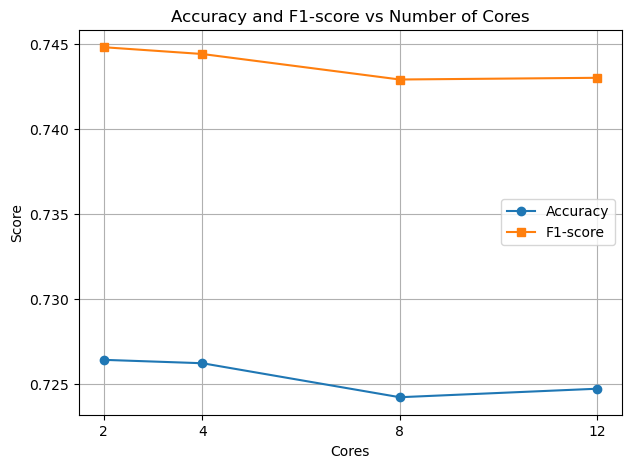

In [17]:
# Naive Bayes Results data
data = {
    "Cores": [2, 4, 8, 12],
    "RunTime (s)": [225.43, 180.04, 156.09, 150.16],
    "Speedup": [1.41, 1.77, 2.04, 2.12],
    "Efficiency": [0.7051, 0.4414, 0.2546, 0.1764],
    "Scalability": [70.51, 44.14, 25.46, 17.64],
    "Accuracy": [0.7264, 0.7262, 0.7242, 0.7247],
    "F1-score": [0.7448, 0.7444, 0.7429, 0.7430]
}

df = pd.DataFrame(data)

# function for consistent plots
def plot_metric(y, title, color="blue", marker="o", ylabel=""):
    plt.figure(figsize=(7,5))
    plt.plot(df["Cores"], df[y], marker=marker, color=color)
    plt.title(title)
    plt.xlabel("Cores")
    plt.ylabel(ylabel if ylabel else y)
    plt.xticks(df["Cores"])
    plt.grid(True)
    plt.show()

# Plots
plot_metric("RunTime (s)", "Runtime vs Number of Cores", "blue", "o", "Runtime (s)")
plot_metric("Speedup", "Speedup vs Number of Cores", "green", "o", "Speedup")
plot_metric("Efficiency", "Efficiency vs Number of Cores", "red", "o", "Efficiency")

# Accuracy and F1-score
plt.figure(figsize=(7,5))
plt.plot(df["Cores"], df["Accuracy"], marker='o', label="Accuracy")
plt.plot(df["Cores"], df["F1-score"], marker='s', label="F1-score")
plt.title("Accuracy and F1-score vs Number of Cores")
plt.xlabel("Cores")
plt.ylabel("Score")
plt.xticks(df["Cores"])  
plt.legend()
plt.grid(True)
plt.show()


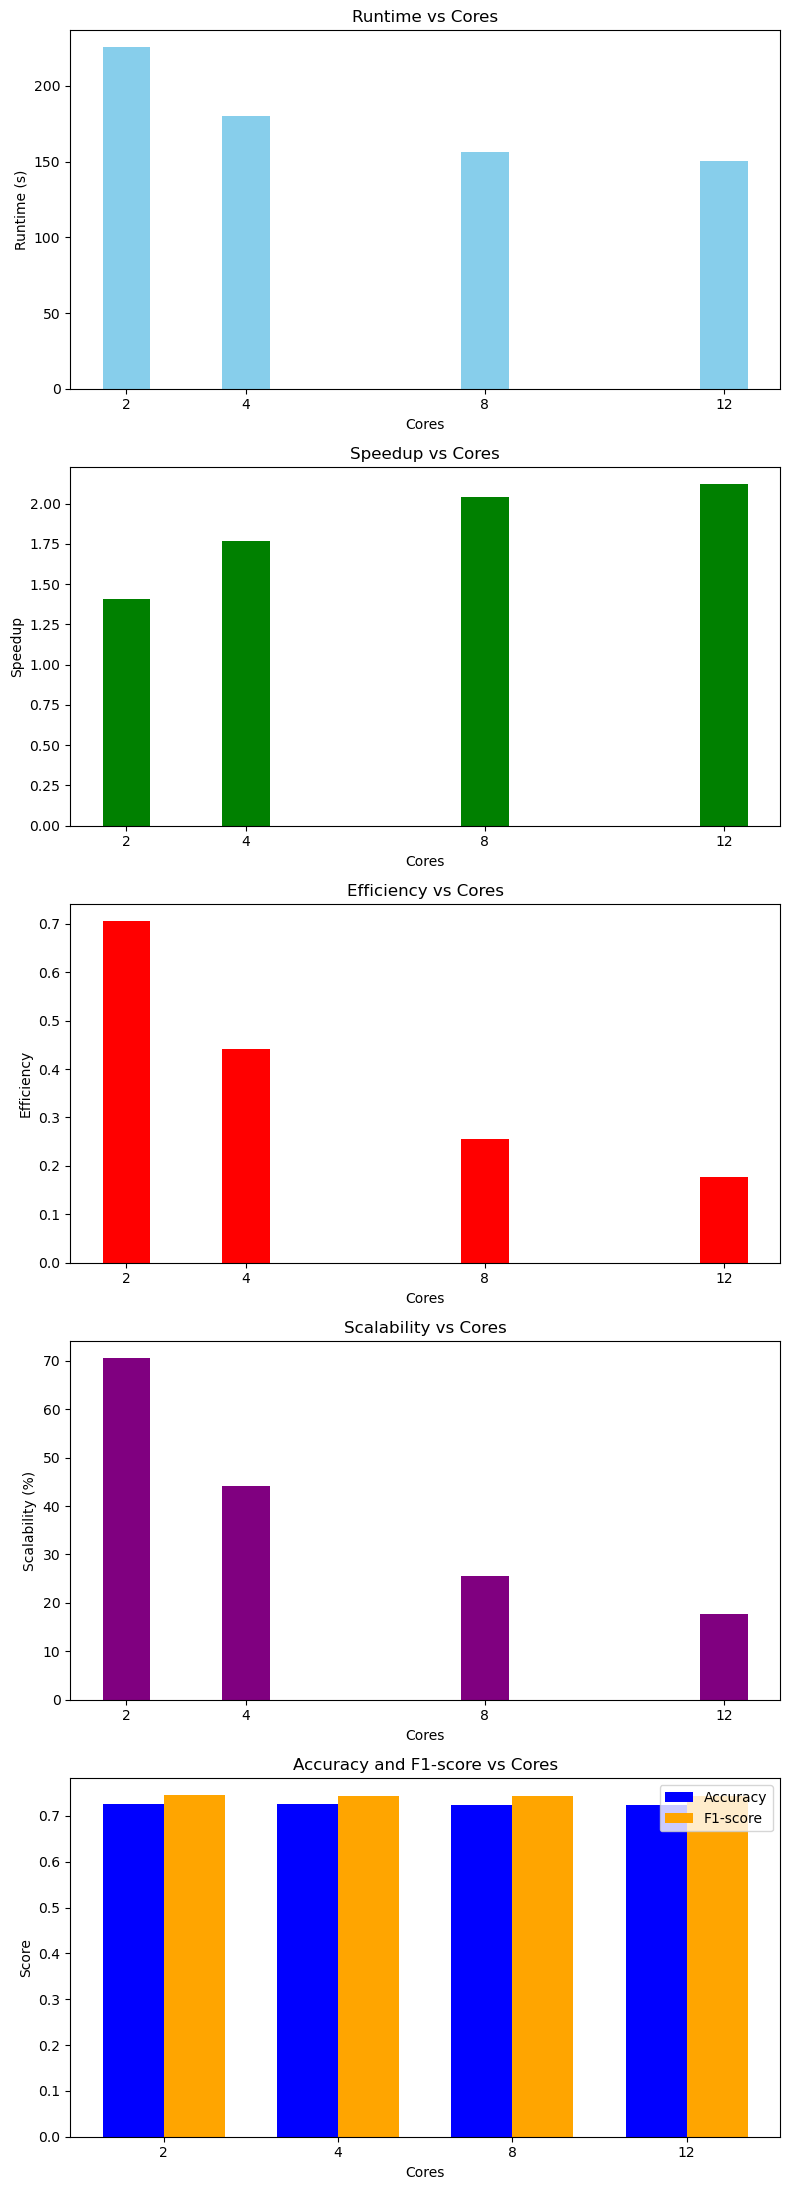

In [18]:
# Naive Bayes Results
data = {
    "Cores": [2, 4, 8, 12],
    "RunTime (s)": [225.43, 180.04, 156.09, 150.16],
    "Speedup": [1.41, 1.77, 2.04, 2.12],
    "Efficiency": [0.7051, 0.4414, 0.2546, 0.1764],
    "Scalability": [70.51, 44.14, 25.46, 17.64],
    "Accuracy": [0.7264, 0.7262, 0.7242, 0.7247],
    "F1-score": [0.7448, 0.7444, 0.7429, 0.7430]
}

df = pd.DataFrame(data)

fig, axes = plt.subplots(5, 1, figsize=(8, 22))

# Runtime
axes[0].bar(df["Cores"], df["RunTime (s)"], color="skyblue")
axes[0].set_title("Runtime vs Cores")
axes[0].set_xlabel("Cores")
axes[0].set_ylabel("Runtime (s)")
axes[0].set_xticks(df["Cores"])

# Speedup
axes[1].bar(df["Cores"], df["Speedup"], color="green")
axes[1].set_title("Speedup vs Cores")
axes[1].set_xlabel("Cores")
axes[1].set_ylabel("Speedup")
axes[1].set_xticks(df["Cores"])

# Efficiency
axes[2].bar(df["Cores"], df["Efficiency"], color="red")
axes[2].set_title("Efficiency vs Cores")
axes[2].set_xlabel("Cores")
axes[2].set_ylabel("Efficiency")
axes[2].set_xticks(df["Cores"])

# Scalability
axes[3].bar(df["Cores"], df["Scalability"], color="purple")
axes[3].set_title("Scalability vs Cores")
axes[3].set_xlabel("Cores")
axes[3].set_ylabel("Scalability (%)")
axes[3].set_xticks(df["Cores"])

# Accuracy & F1-score
width = 0.35
x = range(len(df["Cores"]))
axes[4].bar([i - width/2 for i in x], df["Accuracy"], width, label="Accuracy", color="blue")
axes[4].bar([i + width/2 for i in x], df["F1-score"], width, label="F1-score", color="orange")
axes[4].set_title("Accuracy and F1-score vs Cores")
axes[4].set_xlabel("Cores")
axes[4].set_ylabel("Score")
axes[4].set_xticks(x)
axes[4].set_xticklabels(df["Cores"])
axes[4].legend()

plt.tight_layout()
plt.show()


# Algorithms plot

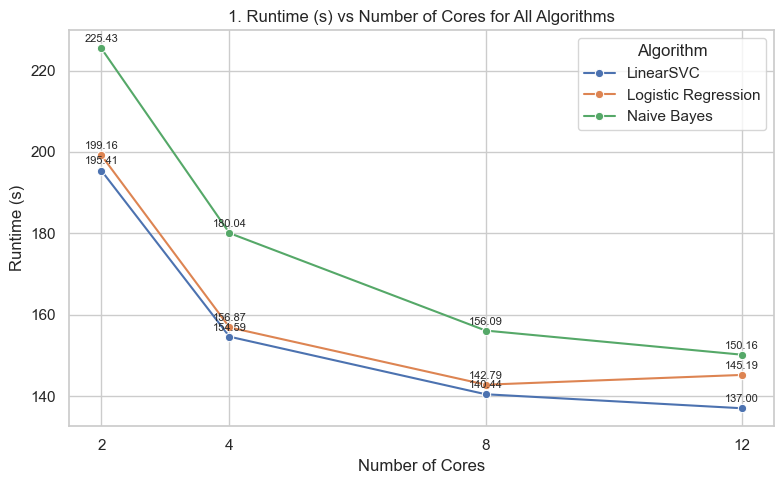

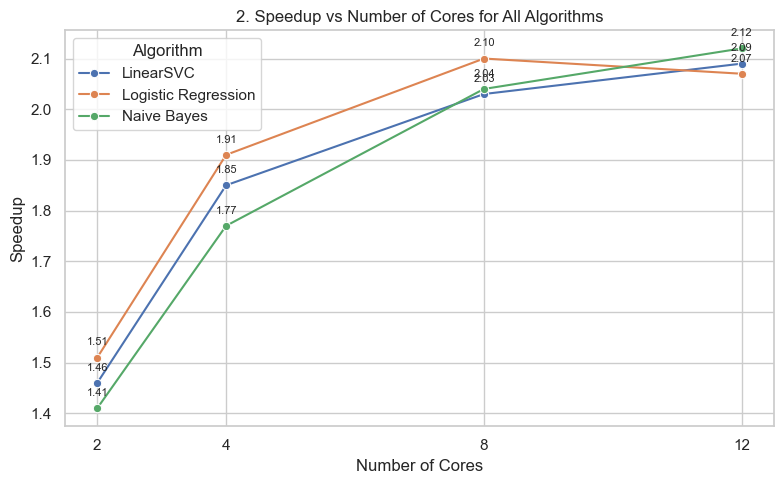

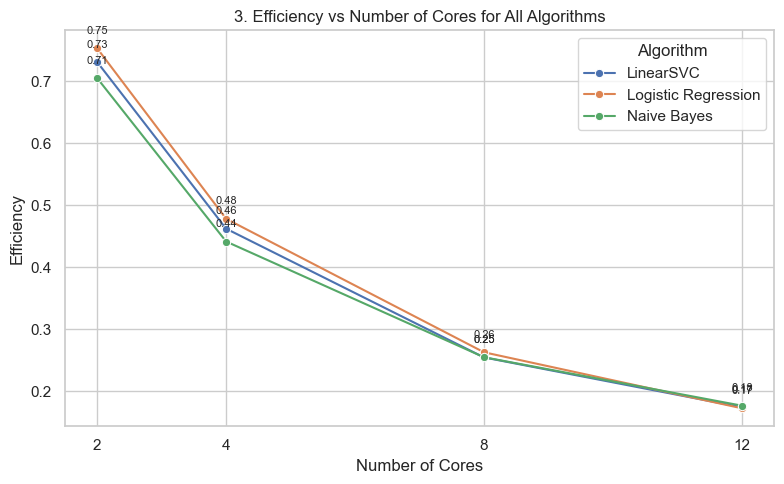

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

cores = [2, 4, 8, 12]

# Runtime
linear_svc_runtime = [195.41, 154.59, 140.44, 137.00]
log_reg_runtime = [199.16, 156.87, 142.79, 145.19]
naive_bayes_runtime = [225.43, 180.04, 156.09, 150.16]

# Speedup
linear_svc_speedup = [1.46, 1.85, 2.03, 2.09]
log_reg_speedup = [1.51, 1.91, 2.10, 2.07]
naive_bayes_speedup = [1.41, 1.77, 2.04, 2.12]

# Efficiency
linear_svc_efficiency = [0.7311, 0.4621, 0.2543, 0.1738]
log_reg_efficiency = [0.7532, 0.4781, 0.2626, 0.1722]
naive_bayes_efficiency = [0.7051, 0.4414, 0.2546, 0.1764]

def plot_metric(values1, values2, values3, metric_name, fig_num):
    data = pd.DataFrame({
        "Cores": cores,
        "LinearSVC": values1,
        "Logistic Regression": values2,
        "Naive Bayes": values3,
    })
    df_long = data.melt(id_vars="Cores", var_name="Algorithm", value_name=metric_name)

    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=df_long, x="Cores", y=metric_name, hue="Algorithm", marker="o")


    for i in range(len(df_long)):
        plt.text(
            df_long["Cores"][i],
            df_long[metric_name][i] + (0.02 if metric_name != "Runtime (s)" else 1),
            f"{df_long[metric_name][i]:.2f}",
            ha='center', va='bottom', fontsize=8
        )

    plt.title(f"{fig_num}. {metric_name} vs Number of Cores for All Algorithms")
    plt.xlabel("Number of Cores")
    plt.ylabel(metric_name)
    plt.xticks(cores)
    plt.legend(title="Algorithm")
    plt.tight_layout()
    plt.show()

plot_metric(linear_svc_runtime, log_reg_runtime, naive_bayes_runtime, "Runtime (s)", 1)
plot_metric(linear_svc_speedup, log_reg_speedup, naive_bayes_speedup, "Speedup", 2)
plot_metric(linear_svc_efficiency, log_reg_efficiency, naive_bayes_efficiency, "Efficiency", 3)
